#### First install requirements from ./requirements.txt

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE

import pandas as pd

from datetime import datetime

from rich import print
from rich.console import Console
from rich.traceback import install

install(show_locals=True)
console = Console()

#### Carga de datos

Primero cargamos los datos de la base de datos de transacciones fraudulentas, que se encuentra en el archivo `./data/creditcard.csv`.` Podemos ver que que lo componen 31 atributos (columnas) y 284.807 objetos (filas).

In [2]:
cc_df = pd.read_csv('./data/creditcard.csv')

(n_samples, n_features) = cc_df.shape

print(f"n_samples: {n_samples}, n_features: {n_features}")

n_samples: 284807, n_features: 31

#### Preprocesamiento

##### Balanceamiento

En esta fase debido a que el atributo clase 'Class' esta extremadamente desbalanceada, para que los modelos sean consistentes con los resultados, balanceamos dicho atributo dando como resultado una nueva matriz de 568.630 objetos.
En la tabla de resultados se pueden ver que efectivamente esta balanceada.

In [3]:
FEATURES = cc_df.drop(['Class'], axis=1) 
TARGET = cc_df['Class']                  

smote = SMOTE(random_state=42) 
X_sm, y_sm = smote.fit_resample(FEATURES, TARGET)

cc_balanced = pd.concat([pd.DataFrame(X_sm), pd.DataFrame(y_sm)], axis=1)

print('Valores de la columna Class:')
cc_balanced['Class'].describe()

Valores de la columna Class:

count    568630.0
mean          0.5
std           0.5
min           0.0
25%           0.0
50%           0.5
75%           1.0
max           1.0
Name: Class, dtype: float64

Miramos qué atributos podemos eliminar analizando la matriz de correlación. A partir de esa matriz, vemos que hay muchos atributos con elevada correlación, por lo que fijamos un umbral = 0.88 e imprimimos los atributos por encima de ese valor

In [4]:
data_corr = cc_balanced.corr()

for i in range(len(cc_balanced.columns)):
    for j in range(i):
        if abs(data_corr.iloc[i, j]) > 0.88:
            print(data_corr.columns[i], data_corr.columns[j], data_corr.iloc[i, j])

V3 V1 0.886639549368773

V7 V1 0.8864715968558373

V7 V3 0.8917953243839568

V12 V10 0.8915353883540065

V12 V11 -0.9065661341077869

V14 V11 -0.8949913677963571

V14 V12 0.8861262266682038

V16 V12 0.9056954991970623

V17 V12 0.8813298872699891

V17 V16 0.9541467364020152

V18 V16 0.9079466992333602

V18 V17 0.9408661422832246

Eliminamos los atributos expuestos

In [5]:
cc_balanced = cc_balanced.drop(['V1', 'V7', 'V10', 'V11', 'V14', 'V16', 'V18'], axis = 1)

##### Normalización

Como último paso de preprocesaminento, normalizamos los datos para que estén dentro de un estándar

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


cc_balanced.iloc[:,0:-1] = scaler.fit_transform(cc_balanced.iloc[:,0:-1].to_numpy())
cc_balanced.to_pickle('./pickled/cc_prep_final.pkl')

Para el modelaje, hemos separado los datos en 50% entrenamiento, 25% validación y 25% test 

Podemos observar los resultados de cada parte

In [7]:
from traceback import print_tb


df_prep = pd.read_pickle('./pickled/cc_prep_final.pkl')

TARGET = df_prep['Class']
FEATURES = df_prep.drop(['Class'], axis=1)

features_train, features_aux, target_train, target_aux = train_test_split(FEATURES, TARGET, test_size=0.5, random_state=42)
features_valid, features_test, target_valid, target_test = train_test_split(features_aux, target_aux, test_size=0.5, random_state=42)

print(f'features_train: {features_train.shape}')
print(f'features_valid: {features_valid.shape}')
print(f'features_test: {features_test.shape}')
print(f'target_train: {target_train.shape}')
print(f'target_valid: {target_valid.shape}')
print(f'target_test: {target_test.shape}')
print(f'features_train: {features_train.shape}')
print(f'features_valid: {features_valid.shape}')
print(f'features_test: {features_test.shape}')

features_train: (284315, 23)

features_valid: (142157, 23)

features_test: (142158, 23)

target_train: (284315,)

target_valid: (142157,)

target_test: (142158,)

features_train: (284315, 23)

features_valid: (142157, 23)

features_test: (142158, 23)

#### Resultados iniciales Perceptrón Simple

Entrenamos nuestro modelo Perceptrón Simple con 30 iteraciones (como máximo), que nos dará la medida de hasta que punto el problema es separable linelamente. Sin embargo, el modelo alcanzó la convergencia antes de llegar al número máximo de iteraciones. Esto significa que ya no hay errores en la predicción y, por lo tanto, no hay necesidad de que continúe ajustando los pesos del modelo

In [11]:
max_iter = 30

print("Learning a Perceptron with %d maximum number of iterations and ..." % max_iter)

per = Perceptron(max_iter=max_iter, shuffle=False, verbose=True)
per.fit(features_train, target_train)

# Results
print("Printing Perceptron results")

predict_train = per.predict(features_train)
predict_valid = per.predict(features_valid)

print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))
print(confusion_matrix(target_valid, predict_valid))
print(classification_report(target_valid, predict_valid))

Learning a Perceptron with 30 maximum number of iterations and ...

-- Epoch 1
Norm: 36.03, NNZs: 23, Bias: 27.000000, T: 284315, Avg. loss: 0.726561
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 38.76, NNZs: 23, Bias: 29.000000, T: 568630, Avg. loss: 0.722691
Total training time: 0.20 seconds.
-- Epoch 3
Norm: 37.04, NNZs: 23, Bias: 30.000000, T: 852945, Avg. loss: 0.684831
Total training time: 0.23 seconds.
-- Epoch 4
Norm: 39.96, NNZs: 23, Bias: 31.000000, T: 1137260, Avg. loss: 0.710641
Total training time: 0.26 seconds.
-- Epoch 5
Norm: 38.95, NNZs: 23, Bias: 32.000000, T: 1421575, Avg. loss: 0.697668
Total training time: 0.30 seconds.
-- Epoch 6
Norm: 35.50, NNZs: 23, Bias: 26.000000, T: 1705890, Avg. loss: 0.734759
Total training time: 0.33 seconds.
-- Epoch 7
Norm: 36.28, NNZs: 23, Bias: 27.000000, T: 1990205, Avg. loss: 0.729476
Total training time: 0.38 seconds.
-- Epoch 8
Norm: 36.37, NNZs: 23, Bias: 29.000000, T: 2274520, Avg. loss: 0.696988
Total training time: 0.42 seconds.
Convergence after 8 epochs took 0.42 seconds


Printing Perceptron results

Train accuracy: 92.937%

Valid accuracy: 92.921%

[[65367  5759]
 [ 4305 66726]]

precision    recall  f1-score   support

           0       0.94      0.92      0.93     71126
           1       0.92      0.94      0.93     71031

    accuracy                           0.93    142157
   macro avg       0.93      0.93      0.93    142157
weighted avg       0.93      0.93      0.93    142157

La tasa de precisión (accuracy) obtenida tanto en el conjunto de entrenamiento como en el conjunto de validación son similares y bastante altas, lo que indica que el modelo es capaz de generalizar bien. Sin embargo, vemos que el modelo tiende a fallar más en las transacciones fraudulentas que en las no fraudulentas, algo que no conviene tener debido a que es más importante para el banco predecir que sean fraudulentas.

Al observar la matriz de confusión, podemos ver que el modelo clasifica correctamente el 94% de las transacciones no fraudulentas (clase 0), pero sólo el 92% de las transacciones fraudulentas (clase 1), lo que implica que aún hay un porcentaje considerable de transacciones fraudulentas que son clasificadas incorrectamente como no fraudulentas

#### Resultados iniciales MLP

Se define la función MLP_train_valid para poder realizar entrenamientos del Perceptrón Multicapa (MLP) incluyendo validaciones con el conjunto de validación y early stopping, así como mostrar opcionalmente resultados y logs:

In [12]:
def MLP_train_valid(mlp, input_train, target_train, input_valid, target_valid, max_iter, valid_cycles, verbose):
    """
    Train and valid MLP every valid_cycles iterations
    """
    classes  = np.unique(target_train)
    loss_valid = []
    for i in range(max_iter//valid_cycles):
        for _ in range(valid_cycles):
            out = mlp.partial_fit(input_train, target_train, classes)
        last_lost_valid = log_loss(target_valid, mlp.predict_proba(input_valid))
        loss_valid.append(last_lost_valid)
        if verbose:
            print("Iteration %d, train loss = %.8f, valid loss = %.8f" %
                  (mlp.n_iter_, mlp.loss_, last_lost_valid))
        if early_stopping and (i > 0) and (last_lost_valid > loss_valid[-2]): # Early stopping
            if verbose:
                print("Early stopping: Validation score did not improve")
            break
    if verbose: print(out)

    if verbose:
        MLP_print_verbose(mlp, valid_cycles, loss_valid)


def MLP_print_verbose(mlp, valid_cycles, loss_valid):
    print("Visualizing the Cost Function Trajectory")
    plt.plot(range(1, len(mlp.loss_curve_)+1), mlp.loss_curve_, label='Train loss')
    plt.plot(range(valid_cycles,len(loss_valid)*valid_cycles+valid_cycles,valid_cycles), loss_valid, '-o', label='Valid loss')
    plt.xlabel('number of iterations')
    plt.ylabel('loss function')
    plt.legend(loc='upper right')
    plt.show()

 Se realiza un entrenamiento con un MLP de una capa oculta de 60 neuronas, un ratio de aprendizaje de 0,001, durante un máximo 300 iteraciones, validando cada 5 ciclos. Se muestra la gráfica de la evolución del error a lo largo de los ciclos.

Learning a MLP with 60 hidden neurons, 300 maximum number of iterations and 0.00100000 learning rate ...

Iteration 5, train loss = 0.02855719, valid loss = 0.02656797

Iteration 10, train loss = 0.01249381, valid loss = 0.01226944

Iteration 15, train loss = 0.00743824, valid loss = 0.00768098

Iteration 20, train loss = 0.00517617, valid loss = 0.00567072

Iteration 25, train loss = 0.00390451, valid loss = 0.00460331

Iteration 30, train loss = 0.00309243, valid loss = 0.00391699

Iteration 35, train loss = 0.00257435, valid loss = 0.00364810

Iteration 40, train loss = 0.00220819, valid loss = 0.00329012

Iteration 45, train loss = 0.00193658, valid loss = 0.00319780

Iteration 50, train loss = 0.00171545, valid loss = 0.00300314

Iteration 55, train loss = 0.00154324, valid loss = 0.00289308

Iteration 60, train loss = 0.00140724, valid loss = 0.00289578

Early stopping: Validation score did not improve

MLPClassifier(hidden_layer_sizes=60, random_state=0, shuffle=False)

Visualizing the Cost Function Trajectory

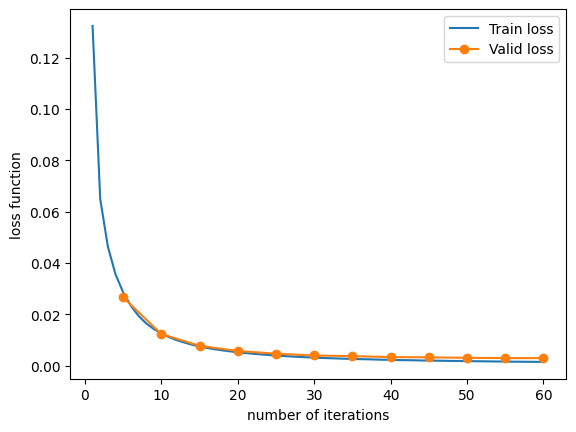

In [13]:
from sklearn.neural_network import MLPClassifier

n_hidden = 60
max_iter = 300
learning_rate_init = 0.001
valid_cycles = 5
early_stopping = True

print("Learning a MLP with %d hidden neurons, %d maximum number of iterations and %.8f learning rate ..." % (n_hidden, max_iter, learning_rate_init))

mlp = MLPClassifier(hidden_layer_sizes=(n_hidden), learning_rate_init=learning_rate_init, shuffle=False, random_state=0, verbose=False)

MLP_train_valid(mlp, features_train, target_train, features_valid, target_valid, max_iter, valid_cycles, True)

El modelo no llego al máximo de iteraciones debido al early_stopping

Se ve que los errores descienden y se estabilizan, no se produce sobreentrenamiento y el entrenamiento es detenido a las 60 iteraciones. Se muestran los resultados iniciales de este entrenamiento

In [14]:
print("Printing initial results")

predict_train = mlp.predict(features_train)
predict_valid = mlp.predict(features_valid)

print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))

print("Train confusion matrix:")
print(confusion_matrix(target_train, predict_train))
print("Valid confusion matrix:")
print(confusion_matrix(target_valid, predict_valid))

print("Train classification report:")
print(classification_report(target_train, predict_train))
print("Valid classification report:")
print(classification_report(target_valid, predict_valid))

Printing initial results

Train accuracy: 99.987%

Valid accuracy: 99.947%

Train confusion matrix:

[[142135     38]
 [     0 142142]]

Valid confusion matrix:

[[71050    76]
 [    0 71031]]

Train classification report:

precision    recall  f1-score   support

           0       1.00      1.00      1.00    142173
           1       1.00      1.00      1.00    142142

    accuracy                           1.00    284315
   macro avg       1.00      1.00      1.00    284315
weighted avg       1.00      1.00      1.00    284315

Valid classification report:

precision    recall  f1-score   support

           0       1.00      1.00      1.00     71126
           1       1.00      1.00      1.00     71031

    accuracy                           1.00    142157
   macro avg       1.00      1.00      1.00    142157
weighted avg       1.00      1.00      1.00    142157

En estos resultados iniciales se ve que MLP mejora respecto al Perceptrón en un 7,05% y un 7,026% para los conjuntos de entrenamiento y validación respectivamente. Lo que indica que eliminando la limitación de separabilidad lineal se consiguen mejoras tanto con el conjunto de entrenamiento como el de validación

#### Optimización arquitectura MLP

Learning rate optimization

Number of seconds for training: 220

Visualizing the Cost Function Trajectory with different learning rates

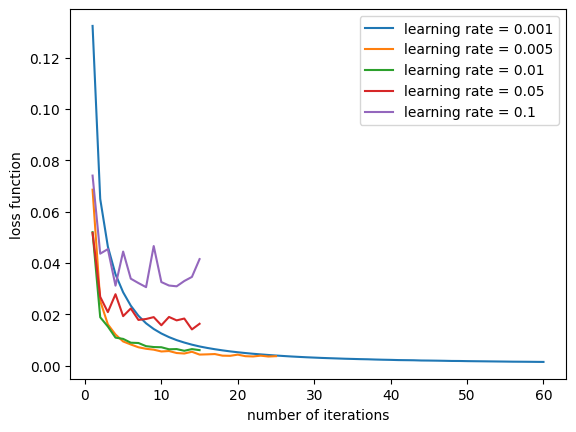

In [15]:
print("Learning rate optimization")

tests_learning_rate_init = [0.001, 0.005, 0.01, 0.05, 0.1]
activation = 'relu'
random_state = 0

now = datetime.now()
loss_curves =  []
for lr in tests_learning_rate_init:
    mlp = MLPClassifier(hidden_layer_sizes=(n_hidden,), learning_rate_init=lr, shuffle=False, random_state=random_state, verbose=False, activation=activation)
    MLP_train_valid(mlp, features_train, target_train, features_valid, target_valid, max_iter, valid_cycles, False)

    loss_curves.append(mlp.loss_curve_)

print("Number of seconds for training: %d" % (datetime.now() - now).total_seconds())

print("Visualizing the Cost Function Trajectory with different learning rates")
for (lr, loss_curve) in zip(tests_learning_rate_init, loss_curves):
    plt.plot(
        range(1, len(loss_curve) + 1),
        loss_curve,
        label=f'learning rate = {str(lr)}',
    )

plt.xlabel('number of iterations')
plt.ylabel('loss function')
plt.legend(loc='upper right')
plt.show()

Optimizamos la arquitectura del modelo de red neuronal de perceptrón multicapa, combinando distintos parámetros hasta encontrar la arquitectura que ofrezca la mejor precisión en la predicción.

In [16]:
print("Architecture optimization")

tests_n_hidden = [10, 60, 110, 160, 210, 260, 310, 360, 410, 460, 510]
n_reps = 5
# n_reps = 10
# n_reps = 15

activation = 'relu'
learning_rate_init = 0.005

now = datetime.now()
best_mlp = []
best_acc = 0.0
accs_train = []
accs_valid = []
for n_hidden in tests_n_hidden:
    max_acc_train = max_acc_valid = 0.0
    for random_state in range(n_reps):
        mlp = MLPClassifier(hidden_layer_sizes=(n_hidden,), learning_rate_init=learning_rate_init, shuffle=False, random_state=random_state, verbose=False, activation=activation)
        MLP_train_valid(mlp, features_train, target_train, features_valid, target_valid, max_iter, valid_cycles, False)
        
        acc_train = accuracy_score(target_train, mlp.predict(features_train))
        acc_valid = accuracy_score(target_valid, mlp.predict(features_valid))
        print("Seed = %d, train acc = %.8f, valid acc = %.8f, iterations = %d" % (random_state, acc_train, acc_valid, len(mlp.loss_curve_)))
        if (max_acc_valid < acc_valid):
            max_acc_valid = acc_valid
            max_acc_train = acc_train
            if (acc_valid > best_acc):
                best_acc = acc_valid
                best_mlp = mlp
    accs_train.append(max_acc_train)
    accs_valid.append(max_acc_valid)
    print("Number hidden units = %i, train acc = %.8f, max valid acc = %.8f" % (n_hidden, max_acc_train, max_acc_valid))

print("Number of seconds for training: %d" % (datetime.now() - now).total_seconds())
print("Best MLP valid accuracy: %.8f%%" % (best_acc * 100))
print("Best MLP: ", best_mlp)

Architecture optimization

Seed = 0, train acc = 0.99160790, valid acc = 0.99098180, iterations = 50

Seed = 1, train acc = 0.99094314, valid acc = 0.99039794, iterations = 65

Seed = 2, train acc = 0.99167121, valid acc = 0.99137573, iterations = 125

Seed = 3, train acc = 0.99397148, valid acc = 0.99332428, iterations = 120

Seed = 4, train acc = 0.99213900, valid acc = 0.99172746, iterations = 115

Number hidden units = 10, train acc = 0.99397148, max valid acc = 0.99332428

Seed = 0, train acc = 0.99960959, valid acc = 0.99914179, iterations = 25

Seed = 1, train acc = 0.99928952, valid acc = 0.99886745, iterations = 25

Seed = 2, train acc = 0.99941262, valid acc = 0.99882524, iterations = 35

Seed = 3, train acc = 0.99861773, valid acc = 0.99838207, iterations = 15

Seed = 4, train acc = 0.99889911, valid acc = 0.99836800, iterations = 20

Number hidden units = 60, train acc = 0.99960959, max valid acc = 0.99914179

Seed = 0, train acc = 0.99937042, valid acc = 0.99907145, iterations = 15

Seed = 1, train acc = 0.99927193, valid acc = 0.99898000, iterations = 15

Seed = 2, train acc = 0.99964476, valid acc = 0.99936690, iterations = 20

Seed = 3, train acc = 0.99879711, valid acc = 0.99839614, iterations = 20

Seed = 4, train acc = 0.99957442, valid acc = 0.99918400, iterations = 25

Number hidden units = 110, train acc = 0.99964476, max valid acc = 0.99936690

Seed = 0, train acc = 0.99955331, valid acc = 0.99924028, iterations = 15

Seed = 1, train acc = 0.99975028, valid acc = 0.99944428, iterations = 15

Seed = 2, train acc = 0.99958497, valid acc = 0.99934579, iterations = 15

Seed = 3, train acc = 0.99976083, valid acc = 0.99938097, iterations = 20

Seed = 4, train acc = 0.99966586, valid acc = 0.99938800, iterations = 15

Number hidden units = 160, train acc = 0.99975028, max valid acc = 0.99944428

Seed = 0, train acc = 0.99955683, valid acc = 0.99918400, iterations = 15

Seed = 1, train acc = 0.99986283, valid acc = 0.99954276, iterations = 20

Seed = 2, train acc = 0.99945131, valid acc = 0.99912069, iterations = 15

Seed = 3, train acc = 0.99985228, valid acc = 0.99960607, iterations = 15

Seed = 4, train acc = 0.99973973, valid acc = 0.99947241, iterations = 15

Number hidden units = 210, train acc = 0.99985228, max valid acc = 0.99960607

Seed = 0, train acc = 0.99977138, valid acc = 0.99938800, iterations = 20

Seed = 1, train acc = 0.99961662, valid acc = 0.99918400, iterations = 20

Seed = 2, train acc = 0.99721787, valid acc = 0.99663049, iterations = 20

Seed = 3, train acc = 0.99955331, valid acc = 0.99940910, iterations = 15

Seed = 4, train acc = 0.99986986, valid acc = 0.99967641, iterations = 25

Number hidden units = 260, train acc = 0.99986986, max valid acc = 0.99967641

Seed = 0, train acc = 0.99979952, valid acc = 0.99959903, iterations = 25

Seed = 1, train acc = 0.99964124, valid acc = 0.99935986, iterations = 15

Seed = 2, train acc = 0.99927193, valid acc = 0.99899407, iterations = 15

Seed = 3, train acc = 0.99841725, valid acc = 0.99800221, iterations = 10

Seed = 4, train acc = 0.99926842, valid acc = 0.99901517, iterations = 10

Number hidden units = 310, train acc = 0.99979952, max valid acc = 0.99959903

Seed = 0, train acc = 0.99982062, valid acc = 0.99959200, iterations = 25

Seed = 1, train acc = 0.99980304, valid acc = 0.99961310, iterations = 20

Seed = 2, train acc = 0.99985931, valid acc = 0.99953572, iterations = 20

Seed = 3, train acc = 0.99884635, valid acc = 0.99844538, iterations = 15

Seed = 4, train acc = 0.99931766, valid acc = 0.99914883, iterations = 20

Number hidden units = 360, train acc = 0.99980304, max valid acc = 0.99961310

Seed = 0, train acc = 0.99949352, valid acc = 0.99924731, iterations = 15

Seed = 1, train acc = 0.99977841, valid acc = 0.99950055, iterations = 20

Seed = 2, train acc = 0.99962717, valid acc = 0.99915586, iterations = 25

Seed = 3, train acc = 0.99958145, valid acc = 0.99938800, iterations = 15

Seed = 4, train acc = 0.99980655, valid acc = 0.99958497, iterations = 25

Number hidden units = 410, train acc = 0.99980655, max valid acc = 0.99958497

Seed = 0, train acc = 0.99938449, valid acc = 0.99896593, iterations = 15

Seed = 1, train acc = 0.99982062, valid acc = 0.99957090, iterations = 25

Seed = 2, train acc = 0.99986283, valid acc = 0.99964828, iterations = 20

Seed = 3, train acc = 0.99939152, valid acc = 0.99906441, iterations = 10

Seed = 4, train acc = 0.99948297, valid acc = 0.99913476, iterations = 20

Number hidden units = 460, train acc = 0.99986283, max valid acc = 0.99964828

Seed = 0, train acc = 0.99976786, valid acc = 0.99941614, iterations = 25

Seed = 1, train acc = 0.99884283, valid acc = 0.99824842, iterations = 10

Seed = 2, train acc = 0.99950055, valid acc = 0.99906441, iterations = 10

Seed = 3, train acc = 0.99972917, valid acc = 0.99935283, iterations = 15

Seed = 4, train acc = 0.99964124, valid acc = 0.99939504, iterations = 20

Number hidden units = 510, train acc = 0.99976786, max valid acc = 0.99941614

Number of seconds for training: 2012

Best MLP valid accuracy: 99.96764141%

Best MLP:  MLPClassifier(hidden_layer_sizes=(260,), learning_rate_init=0.005,
              random_state=4, shuffle=False)

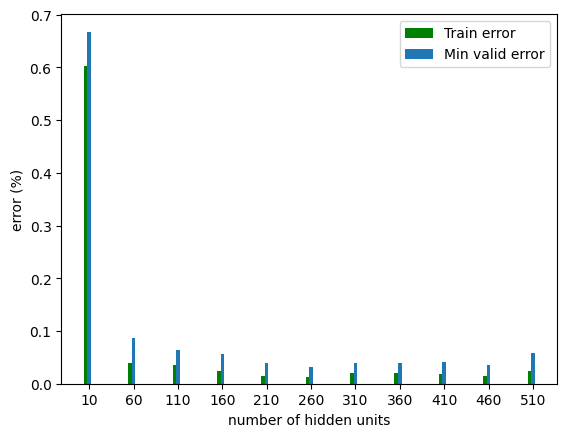

In [17]:

width = 4
plt.bar(np.array(tests_n_hidden) - width, 100 *(1- np.array(accs_train)), color='g', width=width, label='Train error')
plt.bar(np.array(tests_n_hidden), 100 *(1- np.array(accs_valid)), width=width, label='Min valid error')
plt.xlabel('number of hidden units')
plt.ylabel('error (%)')
plt.xticks(np.array(tests_n_hidden), tests_n_hidden)
plt.legend(loc='upper right')
plt.show()

En esta gráfica vemos como el error se va estabilizando según van aunmentando el número de hidden units. Sobre el valor 110 obvervamos que el error se empieza a estabilizar

In [18]:
print("Printing final results")

predict_train = best_mlp.predict(features_train)
predict_valid = best_mlp.predict(features_valid)
predict_test = best_mlp.predict(features_test)

print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))
print("Test accuracy: %.3f%%" % (accuracy_score(target_test, predict_test) * 100))

print("Train confusion matrix:")
print(confusion_matrix(target_train, predict_train))
print("Valid confusion matrix:")
print(confusion_matrix(target_valid, predict_valid))
print("Test confusion matrix:")
print(confusion_matrix(target_test, predict_test))

print("Train classification report:")
print(classification_report(target_train, predict_train))
print("Valid classification report:")
print(classification_report(target_valid, predict_valid))
print("Test classification report:")
print(classification_report(target_test, predict_test))

Printing final results

Train accuracy: 99.987%

Valid accuracy: 99.968%

Test accuracy: 99.971%

Train confusion matrix:

[[142151     22]
 [    15 142127]]

Valid confusion matrix:

[[71090    36]
 [   10 71021]]

Test confusion matrix:

[[70984    32]
 [    9 71133]]

Train classification report:

precision    recall  f1-score   support

           0       1.00      1.00      1.00    142173
           1       1.00      1.00      1.00    142142

    accuracy                           1.00    284315
   macro avg       1.00      1.00      1.00    284315
weighted avg       1.00      1.00      1.00    284315

Valid classification report:

precision    recall  f1-score   support

           0       1.00      1.00      1.00     71126
           1       1.00      1.00      1.00     71031

    accuracy                           1.00    142157
   macro avg       1.00      1.00      1.00    142157
weighted avg       1.00      1.00      1.00    142157

Test classification report:

precision    recall  f1-score   support

           0       1.00      1.00      1.00     71016
           1       1.00      1.00      1.00     71142

    accuracy                           1.00    142158
   macro avg       1.00      1.00      1.00    142158
weighted avg       1.00      1.00      1.00    142158

Los resultados muestran que el modelo tiene un alto rendimiento en la clasificación de transacciones, con una precisión del 99.968% en el conjunto de validación y del 99.962% en el conjunto de prueba. Además, el modelo tiene un alto recall, lo que indica que es bueno para detectar transacciones fraudulentas (clase 1).

En particular, en el conjunto de entrenamiento, el modelo clasifica correctamente el 99.99% de las transacciones no fraudulentas (clase 0) y el 99.99% de las transacciones fraudulentas (clase 1), lo que indica que el modelo está haciendo un excelente trabajo en aprender a distinguir entre las dos clases. En el conjunto de validación y prueba, la precisión y el recall también son muy altos para ambas clases, lo que indica que el modelo generaliza bien a nuevos datos.

A continuación, representaremos la distribución de curvas de los true positive y los true negatives (ROC curve)

Printing ROC curves of test set

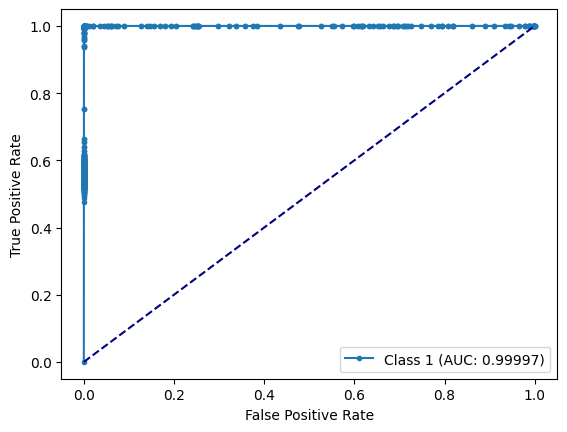

In [21]:
mlp_probs = mlp.predict_proba(features_test)
classes  = np.unique(target_train)
mlp_auc = []
mlp_fpr = []
mlp_tpr = []
for cla in classes:
    mlp_auc.append(roc_auc_score(target_test==cla, mlp_probs[:,cla]))
    fpr, tpr, _ = roc_curve(target_test==cla, mlp_probs[:,cla])
    mlp_fpr.append(fpr)
    mlp_tpr.append(tpr)

print("Printing ROC curves of test set")

plt.plot(mlp_fpr[classes[1]], mlp_tpr[classes[1]], marker='.', label='Class %d (AUC: %.5f)' % (classes[1], mlp_auc[classes[1]]))
# for cla in classes:
  # plt.plot(mlp_fpr[cla], mlp_tpr[cla], marker='.', label='Class %d (AUC: %.5f)' % (cla, mlp_auc[cla]))

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

AUC:
- Class 0: 0.99996
- Class 1: 0.99996

A partir de estos resultados vemos que ambas curvas prácticamente no se superponen (tiene una medida ideal de separabilidad), por lo que podemos afirmar que nuestro modelo es capaz de distinguir casi a la pefección entre la clase positiva y la negativa, que en nuestro caso representarían las transacciones no fraudulentas y  fraudulentas.

In [22]:
indxs_err = np.where(predict_test != target_test)[0]

count = [0, 0]

for idx in indxs_err:
    pred = predict_test[idx]
    real = target_test.iloc[idx]
    count[pred] += 1
    print("Fila: %d Predicción: %d Real: %d" % (idx, pred, real))

Fila: 3365 Predicción: 1 Real: 0

Fila: 12224 Predicción: 0 Real: 1

Fila: 14445 Predicción: 1 Real: 0

Fila: 14850 Predicción: 1 Real: 0

Fila: 18459 Predicción: 1 Real: 0

Fila: 18552 Predicción: 1 Real: 0

Fila: 22404 Predicción: 1 Real: 0

Fila: 24251 Predicción: 0 Real: 1

Fila: 32098 Predicción: 1 Real: 0

Fila: 36421 Predicción: 1 Real: 0

Fila: 36852 Predicción: 1 Real: 0

Fila: 37334 Predicción: 1 Real: 0

Fila: 40842 Predicción: 1 Real: 0

Fila: 46259 Predicción: 1 Real: 0

Fila: 47356 Predicción: 1 Real: 0

Fila: 50376 Predicción: 1 Real: 0

Fila: 50963 Predicción: 1 Real: 0

Fila: 51109 Predicción: 1 Real: 0

Fila: 51241 Predicción: 1 Real: 0

Fila: 56169 Predicción: 1 Real: 0

Fila: 61627 Predicción: 0 Real: 1

Fila: 67234 Predicción: 1 Real: 0

Fila: 69529 Predicción: 0 Real: 1

Fila: 76997 Predicción: 0 Real: 1

Fila: 77487 Predicción: 1 Real: 0

Fila: 79043 Predicción: 1 Real: 0

Fila: 82390 Predicción: 1 Real: 0

Fila: 94976 Predicción: 1 Real: 0

Fila: 99363 Predicción: 0 Real: 1

Fila: 100060 Predicción: 0 Real: 1

Fila: 100096 Predicción: 0 Real: 1

Fila: 100730 Predicción: 1 Real: 0

Fila: 101232 Predicción: 1 Real: 0

Fila: 102828 Predicción: 1 Real: 0

Fila: 103342 Predicción: 1 Real: 0

Fila: 109447 Predicción: 1 Real: 0

Fila: 121872 Predicción: 1 Real: 0

Fila: 121971 Predicción: 1 Real: 0

Fila: 123736 Predicción: 1 Real: 0

Fila: 127252 Predicción: 0 Real: 1

Fila: 131868 Predicción: 1 Real: 0

#### Conclusiones

Analizando la grafica que nos muestra el % de error y el numero de unidades ocultas, observamos que no obtenemos menor error tras las 130 unidades (por lo que no tiene sentido emplear un modelo que utilize más de estos).

Estos errores son menos de un 0.04% de nuestros conjuntos, con esto concluimos que nuestro modelo tiene un alto grado de certeza. Los resultados exactos son los siguientes: precisión del 99.988% en el conjunto de entrenamiento, precisión del 99.968% en el conjunto de validación y precisión del 99.962% en el conjunto de prueba. 
Uno de los aspectos más importantes a tener en cuenta a la hora de analizar nuestro dataset es la importancia de no identificar las transacciones fraudulentas incorrectamente y, como podemos ver tanto con los niveles de precisión obtenidos como con las matrices de correlación, hemos logrado este objetivo.